<a href="https://colab.research.google.com/github/quarcs-lab/pysalnarsc19/blob/master/content/220_geopandas_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Geoprocessing with GeoPandas
============================

We continue exploring geopandas and more of its geoprocessing
capabilities. In this notebook we assume the role of a social scientist
who is interested in the topic of environmental equity. They are broadly
concerned with the question of whether different racial groups are
exposed to different levels of environmental hazards in urban settings.

Their empirical analysis will focus on the case of Riverside County, CA,
where the spatial unit of analysis is the Census tract which we
encountered and processed in the previous notebook. The researcher will
examine the spatial relationships between the highway network and the
census tracts to develop operational measures that feed into their
environmental equity analysis.

In this notebook we focus on generating new features that will be used
in subsequent econometric modeling to test various hypothesis about
environmental justice. We want to create new variables that express the
exposure to the highway network for census tracts in Riverside, CA.

Objectives
----------

-   Processing polyline shapefiles to represent road networks
-   Learn about geographical clipping
-   Integrate spatial data sources with different coordinate reference
    systems
-   Apply buffering to derive new features for subsequent analysis



# Setup

## Install libraries

In [1]:
!pip install -q geopandas
!pip install -q seaborn
!pip install -q shapely


     |████████████████████████████████| 931kB 2.9MB/s 
     |████████████████████████████████| 10.4MB 37.8MB/s 
     |████████████████████████████████| 14.7MB 29.3MB/s 


## Load libraries

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

## Load data from Github 

In [3]:
# It will be cloned for about a 12 hours. That is, you have to re-run this code only after 12 hours
 !git clone --recursive https://github.com/quarcs-lab/pysalnarsc19.git

Cloning into 'pysalnarsc19'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 387 (delta 35), reused 31 (delta 14), pack-reused 318
Receiving objects: 100% (387/387), 73.52 MiB | 10.32 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Checking out files: 100% (148/148), done.


In [4]:
# Let us see what we have inside content/data Folder
 !ls pysalnarsc19/content/data

airbnb.cpg			  participants2016.csv
airbnb.dbf			  participants2017.csv
airbnb.prj			  participants2018.csv
airbnb.shp			  README.md
airbnb.shx			  riverside_city.dbf
airports.csv			  riverside_city.prj
b500.cpg			  riverside_city.qpj
b500.dbf			  riverside_city.shp
b500.prj			  riverside_city.shx
b500.shp			  san_diego.cpg
b500.shx			  san_diego.dbf
behavioralHealth.dbf		  san_diego.prj
behavioralHealth.prj		  san_diego.shp
behavioralHealth.qpj		  san_diego.shx
behavioralHealth.shp		  san_diego.tif
behavioralHealth.shx		  sd_tracts_acs_clean.dbf
CAINC1__ALL_STATES_1969_2017.csv  sd_tracts_acs_clean.prj
CAINC1__definition.xml		  sd_tracts_acs_clean.qpj
CAINC1__Footnotes.html		  sd_tracts_acs_clean.shp
california_tracts.cpg		  sd_tracts_acs_clean.shx
california_tracts.dbf		  texas.dbf
california_tracts.prj		  texas.geojson
california_tracts.shp		  texas.prj
california_tracts.shx		  texas.qgs
city_tracts.cpg			  texas.qpj
city_tracts.dbf			  texas.shp
city_tracts.prj			  texas.shx
city_t

In [0]:
# Load data (from cloned repository)
# db = geopandas.read_file('pysalnarsc19/content/data/texas.shp')

Read a LineString Shapefile
===========================

Thus far we have encountered two different types of geometries in our
shapefiles, namely point and polygons. For our current research, are
going to examine the data set [\"Sanctioned routes for commercial truck
traffic located on the state highway
system](http://www.dot.ca.gov/hq/tsip/gis/datalibrary/Metadata/Trknet.html)\"
from the California Department of Transportation. That has been
downloaded and stored in the `data` directory.

We begin by reading this into a geopandas DataFrame:

In [0]:
routes_df = gpd.read_file('pysalnarsc19/content/data/Truck_Route_Network.shp')

and taking a view of the features

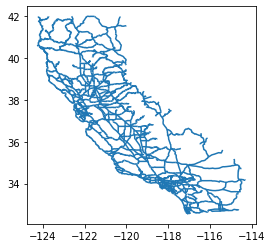

In [6]:
routes_df.plot()

Futhter exploration reveals the geometries are LineStrings

In [7]:
routes_df.head()

,SHAPE_Leng,Beg_Latitu,Beg_Longit,End_Latitu,End_Longit,Route,District,County,Beg_PMPre,Beg_PM,EQ,End_PMPre,End_PM,Segment_Mi,Sp_Restr,Rstr_Type,Segmt_Type,KPRA,Beg_Locati,End_Locati,Comment,seg_length,geometry
0,0.426140,33.467051,-117.669910,33.750992,-118.105912,1,12,ORA,R,0.129,E,None,33.719,33.740,None,0,TA,None,Jct 5,Orange / Los Angeles County Line,None,47438,"MULTILINESTRING ((-117.67002 33.46688, -117.67..."
1,0.420058,33.750992,-118.105912,33.931485,-118.395991,1,7,LA,None,0.000,E,None,25.924,25.858,None,0,TA,None,Pacific Coast Highway,Jct 105 (Imperial Hwy),None,46761,"LINESTRING (-118.10598 33.75104, -118.10618 33..."
2,0.012263,33.931485,-118.395991,33.944521,-118.396115,1,7,LA,None,25.924,None,None,26.870,0.946,R,5,TA,None,Jct 105 (Imperial Hwy),W. Century Blvd.,"Sign on SB 1 at Century Blvd. says ""NO Tank Ve...",1365,"LINESTRING (-118.39611 33.93223, -118.39614 33..."
3,0.101036,33.944521,-118.396115,34.002761,-118.470584,1,7,LA,None,26.897,None,None,33.336,6.439,None,0,TA,None,W. Century Blvd.,Begin Route Break: Lincoln Blvd. near Ozone Ave.,Rte 1 north of Ozone Ave relinquished to City ...,11247,"LINESTRING (-118.39620 33.94487, -118.39619 33..."
4,0.000513,34.002761,-118.470584,34.014809,-118.486011,1,7,LA,None,34.526,E,R,34.576,0.050,None,0,CL,40,End Route Break: Lincoln Blvd. near Olympic Av...,Lincoln Blvd. at I-10 overcrossing in Santa Mo...,None,57,"LINESTRING (-118.48547 34.01443, -118.48547 34..."


In [8]:
routes_df['geometry'].head()

0    MULTILINESTRING ((-117.67002 33.46688, -117.67...
1    LINESTRING (-118.10598 33.75104, -118.10618 33...
2    LINESTRING (-118.39611 33.93223, -118.39614 33...
3    LINESTRING (-118.39620 33.94487, -118.39619 33...
4    LINESTRING (-118.48547 34.01443, -118.48547 34...
Name: geometry, dtype: geometry

Since we will be using this layer with other spatial datasets, it is
good practice to familiarlize ourselves with the Coordinate Reference
System:

In [9]:
routes_df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
routes_df.shape

(966, 23)

So the coordinates in our LineStrings are in longitude and latitude.

Route Clipping
==============

The researcher has the truck route network for the entire state of
California. However, her interest is on the specific case of Riverside
County so she needs a way to extract the portions of the network that
are within the county. This can be done using the geoprocessing
operation *clipping*.

To do this we need to create a layer that will serve to \"clip\" the
road network layer to remove everything outside of Riverside County. We
can use the polygon shapefile we created from the previous notebook:

Read a Polygon Shapefile
------------------------

In [0]:
tracts_df = gpd.read_file('pysalnarsc19/content/data/clinics.shp')

In [12]:
tracts_df.head()

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,DP0010005,DP0010006,DP0010007,DP0010008,DP0010009,DP0010010,DP0010011,DP0010012,DP0010013,DP0010014,DP0010015,DP0010016,DP0010017,DP0010018,DP0010019,DP0010020,DP0010021,DP0010022,DP0010023,DP0010024,DP0010025,DP0010026,DP0010027,DP0010028,DP0010029,DP0010030,DP0010031,DP0010032,DP0010033,DP0010034,...,DP0130002,DP0130003,DP0130004,DP0130005,DP0130006,DP0130007,DP0130008,DP0130009,DP0130010,DP0130011,DP0130012,DP0130013,DP0130014,DP0130015,DP0140001,DP0150001,DP0160001,DP0170001,DP0180001,DP0180002,DP0180003,DP0180004,DP0180005,DP0180006,DP0180007,DP0180008,DP0180009,DP0190001,DP0200001,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,clinics,geometry
0,06065042012,Census Tract 420.12,2687173.0,0.0,+33.9108776,-117.3205065,6242,420,545,620,617,463,393,408,522,528,506,453,277,178,95,87,53,48,29,3018,217,294,303,329,230,193,198,238,231,231,220,139,73,47,...,1522,935,1047,661,128,70,347,204,446,329,152,19,177,37,1028,250,3.16,3.58,2055,1968,87,41,3,25,2,4,12,2.1,4.7,1968,1142,826,3927,2299,3.44,2.78,0.095958,0.000262,0.0,"POLYGON ((-117.30046 33.91311, -117.30068 33.9..."
1,06065041911,Census Tract 419.11,70257842.0,0.0,+33.7428832,-117.4957943,10258,840,844,806,652,446,500,695,958,837,727,657,585,617,480,282,174,100,58,5007,417,437,399,330,229,229,306,477,419,374,327,266,287,231,...,2695,1331,2336,1152,122,56,237,123,616,479,177,44,302,153,1447,794,3.10,3.42,3573,3311,262,19,0,133,24,47,39,4.4,4.2,3311,2881,430,8710,1543,3.02,3.59,0.466106,0.006836,0.0,"POLYGON ((-117.51020 33.80027, -117.50851 33.8..."
2,06065041910,Census Tract 419.10,11167489.0,64225.0,+33.7892199,-117.4949771,6342,404,453,447,436,330,355,418,469,454,425,382,358,490,367,261,149,86,58,3038,197,236,214,217,151,177,187,227,229,222,186,151,219,167,...,1689,711,1360,550,109,48,220,113,484,376,134,40,242,122,790,643,2.92,3.31,2306,2173,133,11,2,59,12,26,23,3.1,3.0,2173,1823,350,5177,1165,2.84,3.33,0.200974,0.001093,0.0,"POLYGON ((-117.50298 33.82495, -117.50291 33.8..."
3,06065040816,Census Tract 408.16,1788821.0,0.0,+33.9024569,-117.5246107,2594,162,161,227,212,193,191,180,202,218,237,226,136,97,53,41,23,18,17,1250,78,75,117,117,96,88,78,101,101,100,120,67,48,27,...,621,339,487,264,44,26,90,49,238,185,84,1,101,13,373,113,3.01,3.58,922,859,63,8,0,34,5,5,11,4.7,4.5,859,688,171,2133,451,3.10,2.64,0.082444,0.000174,0.0,"POLYGON ((-117.51512 33.90097, -117.51532 33.9..."
4,06065040815,Census Tract 408.15,1266779.0,0.0,+33.8930776,-117.5114997,3586,231,235,257,289,279,330,279,268,258,268,273,242,155,85,51,41,20,25,1733,112,105,139,138,150,162,134,130,121,125,129,111,82,36,...,875,412,635,304,70,42,170,66,280,201,87,13,114,17,485,171,3.10,3.56,1205,1155,50,17,1,16,2,4,10,2.1,4.1,1155,756,399,2462,1124,3.26,2.82,0.050637,0.000123,0.0,"POLYGON ((-117.50386 33.89736, -117.50357 33.8..."


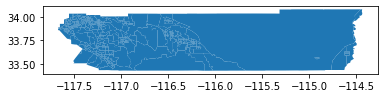

In [13]:
tracts_df.plot()

Get routes intersecting Riverside County
----------------------------------------

To select only the routes within Riverside County we could take several
approaches. We have the tract layer for the county that has 453 tracts,
as well as the road network layer for the state. That has 966 segments.
We could then use the intersects method for each tract to test if it
intersects with a particular segment of the road network, and then keep
all the segments where we find an intersection with the tract.

While this would work, it turns out to be very inefficient as a brute
force approach would require we compare each of 453 tracts against each
of 966 segments and test for an intersection.

We can do better.

If we think about our problem from a slightly different perspective, we
know that if we find a segment that intersects with a tract within
Riverside county, it must, by definition, intersect with the County
polygon, if we had such a thing.

This would substantially reduce the number of intersection tests (or
more broadly, \"hit tests\") we need to conduct. Rather than having to
compare 453 tract polygons with 966 road segments, we now only need
compare 1 polygon against each of the road segments. That is a 453X
reduction in computation. Nice.

### Dissolve

Ok, but we do not yet have the magical county polygon. It seems worth it
to get one, and using another method of the geopandas DataFrame for the
tracts, we can. First, we can re-examine our DataFrame:

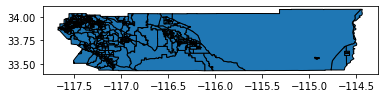

In [14]:
tracts_df.plot(edgecolor='k')

What we are going to do is dissolve all the tract boundaries that do not
coincide with the boundary of the DataFrame\'s geometry collection.

This is done by creating a new attribute that takes on the same values
for each feature, and calling the `dissovle` method with that attribute
as the argument to the `by` option:

In [0]:
tracts_df['dummy'] = 1.0
county = tracts_df.dissolve(by='dummy')

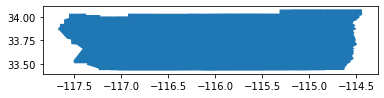

In [16]:
county.plot()

In [17]:
county.shape

(1, 196)

Note that we could have also obtained this polygon by using the
`unary_union` method of the GeoSeries:

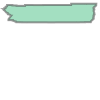

In [18]:
county_uu = tracts_df['geometry'].unary_union
county_uu

This gives us a Shapely Polygon. We would then have toconstruct a new
GeoDataFrame with this as the Geometry column. Instead, we will continue
with the `county` DataFrame obtained from the dissolve operation since
this saves us one step. (We simply note the unary~union~ as you never
know when you may need it.)

We now have our single polygon for the county.

In our earlier notebook we saw that care needs to be taken when testing
for intersections between features from two different DataFrames, as
this is done on an element-wise basis.

There are a couple of ways to handle this. First, using what are known
as **lambdas**:

In [0]:
r = routes_df['geometry']

In [20]:
type(r)

geopandas.geoseries.GeoSeries

In [21]:
r.apply(lambda x: x.intersects(county.iloc[0]['geometry']))

0      False
1      False
2      False
3      False
4      False
       ...  
961    False
962    False
963    False
964    False
965    False
Name: geometry, Length: 966, dtype: bool

In [0]:
rc_routes = r[r.apply(lambda x: x.intersects(county.iloc[0]['geometry']))]

In [23]:
rc_routes.shape

(42,)

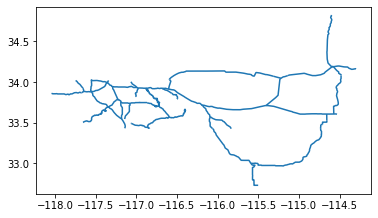

In [24]:
rc_routes.plot()

Plotting the two layers to see what we are now working with gives us:

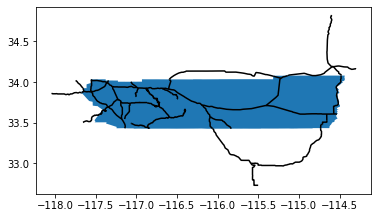

In [25]:
ax = plt.gca()
rc_routes.plot(ax=ax, edgecolor='k')
county.plot(ax=ax)
plt.show()

Lambdas are handy, but tend to make code a little more difficult to
read. Technically they are known as \"anonymous functions\". A more
transparent approach is to use a simple loop and test each route segment
for intersection with the county, and append the segment to a list to
store all the segments that intersect with the county:

In [26]:
geoms = []
for idx, route in enumerate(rc_routes):
    print(idx)
    geoms.append(route.intersection(county.iloc[0]['geometry']))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


Now we use this Python list of intersection objects (which are segments)
into a GeoSeries:

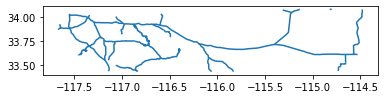

In [27]:
rc_hw = gpd.GeoSeries(geoms)
rc_hw.plot()

and, plot the new series with our county polygon:

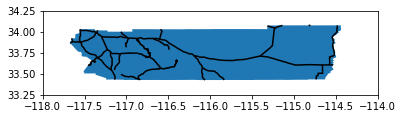

In [28]:

ax = plt.gca()
county.plot(ax=ax)
rc_hw.plot(ax=ax, edgecolor='k')
ax.set_xlim(-118.0, -114.0); ax.set_ylim(33.25, 34.25)
ax.set_aspect('equal')
plt.show()

we set the limits for the horizontal and vertical axes to zoom in. We
can also change the plot size:

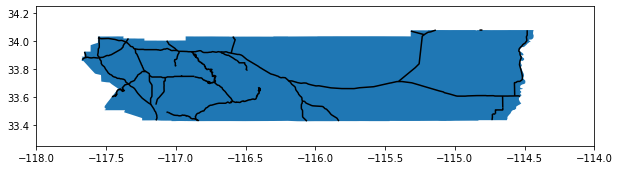

In [29]:
plt.rcParams['figure.figsize'] = (10, 8)
ax = plt.gca()
county.plot(ax=ax)
rc_hw.plot(ax=ax, edgecolor='k')
ax.set_xlim(-118.0, -114.0); ax.set_ylim(33.25, 34.25)
ax.set_aspect('equal')
plt.show()

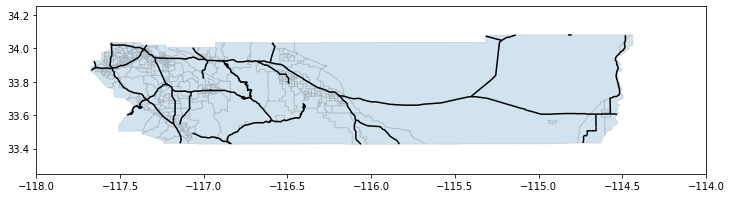

In [30]:
plt.rcParams['figure.figsize'] = (12, 10)
ax = plt.gca()
tracts_df.plot(ax=ax, edgecolor='grey', alpha=0.2)
rc_hw.plot(ax=ax, edgecolor='k')
ax.set_xlim(-118.0, -114.0); ax.set_ylim(33.25, 34.25)
ax.set_aspect('equal')
plt.show()

And finally, let us create a DataFrame from the GeoSeries:

In [31]:
type(rc_hw)

geopandas.geoseries.GeoSeries

In [0]:
rc_hw = gpd.GeoDataFrame({'geometry': rc_hw})

In [33]:
rc_hw.shape

(42, 1)

In [34]:
tracts_df.shape

(453, 197)

Spatial Joins: Which Tracts Intersect the Truck Network?
========================================================

We now have the truck route network clipped to the extent of Riverside
County. Using this layer, we can determine which census tracts intersect
the network within the county. For this, we revisit the concept of a
spatial join. There are different flavors of spatial joins that can be
used in practice. Here we explore the options before deciding which one
serves our particular need best.

We begin with a so called \"inner\" join:

In [35]:
# spatial join, tracts with roads
tracts_with_roads = gpd.sjoin(tracts_df, rc_hw, how='inner', op='intersects')

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4269 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)
/usr/local/lib/python3.6/dist-packages/geopandas/base.py:104: UserWarning: Cannot generate spatial index: Missing package `rtree`.
  warn("Cannot generate spatial index: Missing package `rtree`.")


AttributeError: ignored

We see the warning about the CRS mismatch. Let us see what is going on:

In [0]:
tracts_df.crs

and

In [0]:
rc_hw.crs

So the route DataFrame does not have a CRS. We can correct this by
setting it to that of the tracts data frame:

In [0]:
rc_hw.crs = tracts_df.crs # create a crs for the rc_hw
rc_hw = rc_hw.to_crs(tracts_df.crs) # update the coordinates accordingly

and when we repeat the join:

In [0]:
# spatial join, tracts with roads
tracts_with_roads = gpd.sjoin(tracts_df, rc_hw, how='inner', op='intersects')

Silence is golden.

Now we can see what our join operation has returned. We stored the
results in a new object:

In [0]:
tracts_with_roads.head()

If we scroll to the right of the DataFrame output, we see a column
labeled **index~right~**. The values in this column indicate the index
of the features in the right DataFrame (in our case the road network)
that intersect with the feature in the current row of the left DataFrame
(the tracts).

Plotting the resulting DataFrame we see:

In [0]:
tracts_with_roads.plot(edgecolor='grey', alpha=0.2)

Close inspection reveals some missing tracts. What is going on here?

In [0]:
tracts_with_roads.shape

We see there are 256 features in our new DataFrame resulting from the
join. But this is less than the number of tracts in the county:

In [0]:
tracts_df.shape

So our plot is not incorrect. It is giving us what we asked for - a plot
of the DataFrame for the tracts that intersect the truck network.

A second type of join can be obtained by setting the `how` option to
`'left'`:

In [0]:
# spatial join, tracts with roads
tracts_with_roads = gpd.sjoin(tracts_df, rc_hw, how='left', op='intersects')

This overwrites the resulting DataFrame, so the number of features
changes:

In [0]:
tracts_with_roads.shape

This is a larger number than the number of tracts. What is going on?

In [0]:
## 'how=left' uses keys from left_df and retains left_df geometry
# shows all tracts with or withing intersection with network
tracts_with_roads.plot(edgecolor='grey', alpha=0.2)

The plot doesn\'t suggest anything fishy. More introspection:

In [0]:
tracts_with_roads.head()

Again, scrolling to the right we see the **index~right~** column, but
now we see a mixture of `NaN` and numerical values. The `NaN` values
appear in rows for tracts that do not intersect the road network. Hence
there is no feature in the right DataFrame that intersects with that
feature in the left DataFrame.

But, this doesn\'t explain why we have more features in the resulting
DataFrame than in the left data frame. Something else must be happening.
And it is:

In [0]:
len(tracts_with_roads['GEOID10'].unique())

We have the correct number of unique geographic identifiers. Using these
we can determine how many records we have for each unique identifier
(tract):

In [0]:
tracts_with_roads.groupby(['GEOID10']).size()

Ah, there are some tracts that appear multiple times in the resulting
DataFrame. We can examine one of these using

In [0]:
tracts_with_roads[tracts_with_roads['GEOID10']=='06065030502']

and scrolling over to the right of the output cell reveals that the
tract with the GEOID10 of 06065030502 intersects with three different
segments of the road network: 29.0, 39.0, and 3.

What has happen is the \'left\' join keeps all of the features from the
left database and reports either an `NaN` value, or each unique
intersection between the tract and a particular segment of the road
network. In other words, there will be at least as many features in the
resulting DataFrame as in the left DataFrame. There will be more when
one or more features from the left data frame intersects with more than
a single feature from the right DataFrame.

Thus far we have examined a \"inner\" join and a \"left\" join. The
final option is a \"right\" join:

In [0]:
# spatial join, tracts with roads
tracts_with_roads = gpd.sjoin(tracts_df, rc_hw, how='right', op='intersects')

In [0]:
tracts_with_roads.shape

There is that number again: 256. What is happening here?

In [0]:
## 'how=right' uses keys from right DataFrame and retains right df geometry
tracts_with_roads.plot(edgecolor='grey', alpha=0.2)

These are not tracts but rather the LineStirngs. What is happening is
that a `right` join keeps each of the features from the right DataFrame
and lists each unique intersection with a feature from the left
DataFrame:

So, if we are interested in the question of whether tracts intersecting
the highway network are different from those not interseting the
highways, which one do we want?

There are several ways we could do this, but the approach we take here
is to use the inner join:

In [0]:
tracts_with_roads = gpd.sjoin(tracts_df, rc_hw, how='inner', op='intersects')

In [0]:
tracts_with_roads.shape

With this in hand, we can create an indicator variable for use in
subsequent analysis. Here the indicator will be 1 if the tract
intersects one or more route segments, and zero other wise:

In [0]:
# Let's create an indicator (dummy) variable for use later
import numpy as np
geoids = tracts_df['GEOID10'].values
tract_hw = np.array([geoid in tracts_with_roads['GEOID10'].values for geoid in geoids])

tract_hw

We convert the Boolean valued array into a numerical type and store it
in our indicator variable `intersectshw` in our tract DataFrame:

In [0]:
tracts_df['intersectshw'] = tract_hw*1.

We can now visualize our work:

In [0]:
tracts_df.plot()

That plots the entire DataFrame. We would like to distinguish tracts
that intersect the network from those that do not:

In [0]:
tracts_df.plot(column='intersectshw')

Great, but which color represents the tract intersecting the network? We
can tighten up this visualization:

In [0]:
plt.rcParams['figure.figsize'] = (12, 10)
ax = plt.gca()
tracts_df.plot(ax=ax, column='intersectshw',edgecolor='grey', alpha=0.2)
rc_hw.plot(ax=ax, edgecolor='k')
ax.set_xlim(-118.0, -114.0); ax.set_ylim(33.25, 34.25)
ax.set_aspect('equal')
plt.show()

And we see the results of our geoprocessing.

We can save our DataFrame by writing it out to a shapefile for future
analysis.

In [0]:
# save our work to an augmented shapefile
tracts_df.to_file('data/tracts_routes.shp')

Spatial Joins: Take Two
=======================

Our social scientist is pretty happy with what she has been able to
accomplish with Geopandas and its geoprocessing.

Taking advantage of these new skills, she wants to further refine the
scope of her analysis as she realizes much of the eastern part of the
county consists of very large census tracts with low population. So she
decides to focus only on the case of the City of Riverside.

She has obtained a shapefile for the official city boundaries from the
[California Department of
Transportation](http://www.dot.ca.gov/hq/tsip/gis/datalibrary/zip/Boundaries/Cities2015.zip):

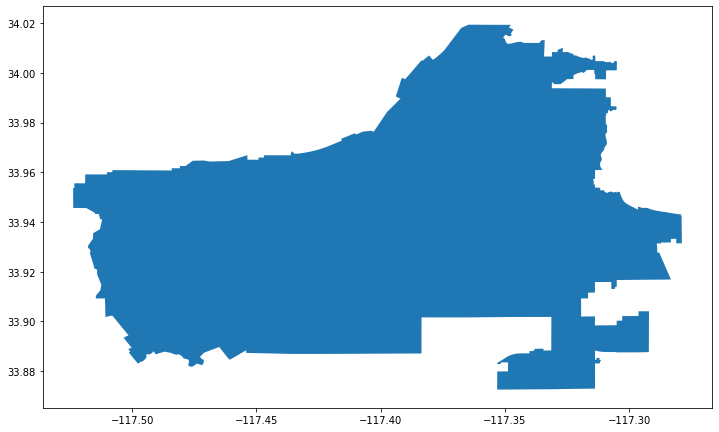

In [36]:
city = gpd.read_file('pysalnarsc19/content/data/riverside_city.shp')

city.plot()

And she uses this to do a spatial join to determine which tracts in
Riverside County are within Riverside City:

In [37]:
city_tracts = gpd.sjoin(tracts_df, city, how='inner', op='intersects')

city_tracts.head()

AttributeError: ignored

In [0]:
city_tracts.shape

In [0]:
city_tracts.plot(edgecolor='grey',facecolor='white')

Recall that previously we created the indicator variable `intersectshw`
for all the tracts in Riverside County that intersected with the road
network. One of the nice features of GeoPandas is that for many of the
geoprocessing operations, the attributes are passed along to the derived
GeoDataFrames. In our case, `city_tracts` is really just a subset of
`tracts_df` so since the latter was the DataFrame that we originally
defined the `intersectshw` variable, that attribute gets propagated
along to the derived `city_tract` GeoDataFrame.

In [0]:
city_tracts.plot(column='intersectshw', edgecolor='grey')

In [0]:
city_tracts.head()

In [0]:
plt.rcParams['figure.figsize'] = (12, 10)
ax = plt.gca()
city_tracts.plot(ax=ax, column='intersectshw',edgecolor='grey', alpha=0.2)
rc_hw.plot(ax=ax, edgecolor='k')
ax.set_xlim(-118.0, -114.0); ax.set_ylim(33.25, 34.25)
ax.set_aspect('equal')
plt.show()

Using the `total_bounds` of the new DataFrame we can zoom in to the
western part of Riverside County that is centered on the City of
Riverside:

In [0]:
w, s, e, n = city_tracts.total_bounds
w, s, e, n

In [0]:
plt.rcParams['figure.figsize'] = (12, 10)
ax = plt.gca()
city_tracts.plot(ax=ax, column='intersectshw',edgecolor='grey', alpha=0.2)
rc_hw.plot(ax=ax, edgecolor='k')
ax.set_xlim(w, e); ax.set_ylim(s, n)
#ax.set_aspect('equal')
plt.show()

Buffering
=========

Our researcher has identified the tracts that intersect the truck route
network and has sharpened the lens to the City of Riverside. However,
zooming in further she sees a geographical relationship that gives her
pause:

In [0]:
plt.rcParams['figure.figsize'] = (12, 10)
ax = plt.gca()
city_tracts.plot(ax=ax, column='intersectshw',edgecolor='grey', alpha=0.2)
rc_hw.plot(ax=ax, edgecolor='k')
ax.set_xlim(-117.53, -117.37); ax.set_ylim(33.875, 33.975)
#ax.set_aspect('equal')
plt.show()

It seems to her that there are cases where a segment of the road network
separates two tracts, yet only one of those tracts is identified as
intersecting the network. While tracts are typically defined using
blocks and street center lines she would expect the tracts that share a
road segment as a common part of their respective borders should both be
considered intersecting the network. For her environmental equity
analysis she thinks that individuals that are equidistant from the
network, but on opposite sides of the highway, should face the same
level of exposure. Yet, the variable she has painstakingly constructed
thus far would give an asymmetric exposure measure to these individuals.

There are several reasons these apparent inconsistencies can arise.
First, the origin of the tract boundaries is different from that of the
route network so there is no guarantee that the same digitization
process was used. Second, even if the same agency/researcher did the
digitization of the two layers, if they do not follow good practice, the
topological relationships may be in error. In either case, the two
layers may be yield these kinds of inconsistencies when considered
together.

Fortunately, our researcher knows about the concept of **buffering** and
can call on this to develop a more robust representation of proximity to
the highway. The idea is to define a critical distance, say 500 feet,
and then define a new polygon that contains all of the points that are
within 500 feed of the route network. The resulting polygon is called a
**buffer**.

Once we have the 500-ft buffer, we can then repeat our intersection test
for the tracts to see which tracts are within 500 feet of the route
network. This would address the asymmetry problem our researcher has
identified.

One issue we face, however, is that the tract CRS is unprojected:

In [0]:
tracts_df.crs

In other words, if we ignore the CRS, our distances are going to be in
decimal degrees and not feet. So we need to put the tracts on a CRS with
more appropriate units. Fortunately, our behavioral clinics data set has
just such a CRS:

In [0]:
clinics = gpd.read_file('data/behavioralHealth.shp')

In [0]:
clinics.crs

And, we can change the CRS of the city~tracts~ to that of the clinics:

In [0]:
city_tracts = city_tracts.to_crs(clinics.crs)

In [0]:
city_tracts.plot()

Notice that the units on the axes have changed from what we had above.

Since we will be doing a buffer around the segments of the highway in
the county as well

In [0]:
rc_hw.plot()

In [0]:
type(rc_hw)

In [0]:
rc_hw = rc_hw.to_crs(city_tracts.crs)

In [0]:
rc_hw.plot()

Now we can define the buffer. If we

In [0]:
buf = rc_hw.buffer(500)

In [0]:
buf.plot()

In [0]:
rc_hw.columns

Cool. That gives us a buffer but for the network in the entire county.
What about just in the city?

In [0]:
city_tracts.columns

Now if we just want the segments in the city boundaries, we know a
spatial join can get us these:

In [0]:
city_hw = gpd.sjoin(routes_df, city, how='inner', op ='intersects')

In [0]:
city_hw.plot()

and, we take care to set its CRS accordingly:

In [0]:
city_hw = city_hw.to_crs(city_tracts.crs)

In [0]:
city_hw.plot()

And, we can buffer these segments:

In [0]:
b500 = city_hw.buffer(500)

In [0]:
b500.plot()

In [0]:
ct = city_tracts[['GEOID10', 'geometry']]
b500 = gpd.GeoDataFrame({'geometry': b500})
b500.crs = ct.crs

Now we can ask to find the tracts in Riverside City that intersect with
the 500-ft buffer around the highways:

In [0]:
tracts_intersecting_hw = gpd.sjoin(ct, b500, how='inner', op='intersects')

In [0]:
tracts_intersecting_hw.plot()

This creates a new DataFrame with only those tracts for which the hit
test (buffer intersection) is True:

In [0]:
tracts_intersecting_hw.shape

Now can create a dummy variable for these tracts to place back in the
DataFrame that contains all the city tracts:

In [0]:
geoids = city_tracts['GEOID10'].values
tract_hw = np.array([geoid in tracts_intersecting_hw['GEOID10'].values for geoid in geoids])
tract_hw

In [0]:
city_tracts['b500'] = tract_hw * 1

In [0]:
city_tracts.plot()

Comparing our two different operational constructs for environmental
equity we have:

In [0]:
city_tracts.plot(column='b500',edgecolor='grey')

In [0]:
w, s, e, n = city_tracts.total_bounds
plt.rcParams['figure.figsize'] = (12, 10)
ax = plt.gca()
city_tracts.plot(ax=ax, column='intersectshw',edgecolor='grey', alpha=0.2)
b500.plot(ax=ax, edgecolor='k')
ax.set_xlim(w, e); ax.set_ylim(s, n)
#ax.set_aspect('equal')
plt.show()

In [0]:
w, s, e, n = city_tracts.total_bounds
plt.rcParams['figure.figsize'] = (12, 10)
ax = plt.gca()
city_tracts.plot(ax=ax, column='b500',edgecolor='grey', alpha=0.2)
b500.plot(ax=ax, edgecolor='k')
ax.set_xlim(w, e); ax.set_ylim(s, n)
#ax.set_aspect('equal')
plt.show()

And we save our tracts and buffer to their own shapefiles for the next
phase of our analysis.

In [0]:
city_tracts.to_file('data/city_tracts.shp')
b500.to_file('data/b500.shp')

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geoprocessing with GeoPandas</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.